In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps

def generate_SIR(S_init = 0.2, I_init = 10e-10):
    ##############################
    # Generate an SIR model
    # Returns: S and I evolved over time
    ##############################

    num_years = 2000
    weeks_per_year = 52

    # Initial conditions:
    S_0 = S_init
    I_0 = I_init
    beta_0 = 0.8 / weeks_per_year
    beta_1 = 0.025 / weeks_per_year
    gamma = 0.2 / weeks_per_year          # per capita recovery rate
    phi = np.pi * 0.                      # seasonal phase shift

    mu = 5.4795*10e-5 / weeks_per_year # birth rate
    nu = 5.4795*10e-5 / weeks_per_year # death rate

    t = np.linspace(0, num_years, num_years * weeks_per_year)
    beta = np.zeros(len(t))
    S = np.zeros(len(t))
    I = np.zeros(len(t))

    S[0] = S_0
    I[0] = I_0

    for week in range(0,len(t)-1):
        beta[week] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(week)/(1/weeks_per_year) - phi))
        S[week+1] = S[week] + nu - beta[week] * S[week] * I[week] - mu * S[week]
        I[week+1] = I[week] + beta[week] * S[week] * I[week] - gamma * I[week] - mu * I[week]

    beta[len(t)-1] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(t[-1]) - phi))
    
    return t, S, I, beta


def add_noise(S, I, additive_noise_level = 1e-50):

    ##############################
    # Add noise to S and I
    # Returns: A Noisy version of S and I
    ##############################

    np.random.seed(0)
    noiseS = additive_noise_level * np.random.randn(1,len(t)).squeeze()
    noiseI = additive_noise_level * np.random.randn(1,len(t)).squeeze()

    return S + noiseS, I + noiseI


def apply_sindy(S, I, beta, threshold=10e-3):

    ##############################
    # Construct SINDy model for SIR
    # Returns: Trained Model
    ##############################

    poly_lib1 = ps.PolynomialLibrary(degree=3, interaction_only=True)
    poly_lib2 = ps.PolynomialLibrary(degree=2, interaction_only=False)

    generalized_library = ps.GeneralizedLibrary(
        [poly_lib1, poly_lib2],
        # tensor_array=tensor_array,
        # exclude_libraries=excluded_values,
        # inputs_per_library=inputs_per_library,
    )

    optimizer = ps.STLSQ(threshold=threshold, normalize_columns=True)

    x_data = np.transpose(np.array([S,I]))

    sir_model = ps.SINDy(
        # differentiation_method=differentiation_method,
        feature_library=generalized_library,
        optimizer=optimizer,
        feature_names=["S","I","beta"],
        discrete_time=True
    )

    sir_model.fit(x_data, t=t, u=beta)

    return sir_model

In [272]:
light_noise_value = 1e-9
med_noise_value = 1e-7
heavy_noise_value = 1e-5

init_value = np.array([0.2 ,10e-10]) # S-0 and I_0

t, S, I, beta = generate_SIR(S_init=init_value[0], I_init=init_value[1])
Slight, Ilight = add_noise(S, I,  light_noise_value)
Smed, Imed = add_noise(S, I,  med_noise_value)
Slarge, Ilarge = add_noise(S, I,  heavy_noise_value)

light_noise_model = apply_sindy(Slight, Ilight, beta, 10e-3)
med_noise_model = apply_sindy(Smed, Imed, beta, 10e-3)
large_noise_model = apply_sindy(Slarge, Ilarge, beta, 10e-3)

##############################
# Simulate using SINDy model
##############################

# init_value = x_data[0]
sim_light = light_noise_model.simulate(init_value, t=len(t), u=beta)
sim_med = med_noise_model.simulate(init_value, t=len(t), u=beta)
sim_large = large_noise_model.simulate(init_value, t=len(t), u=beta)

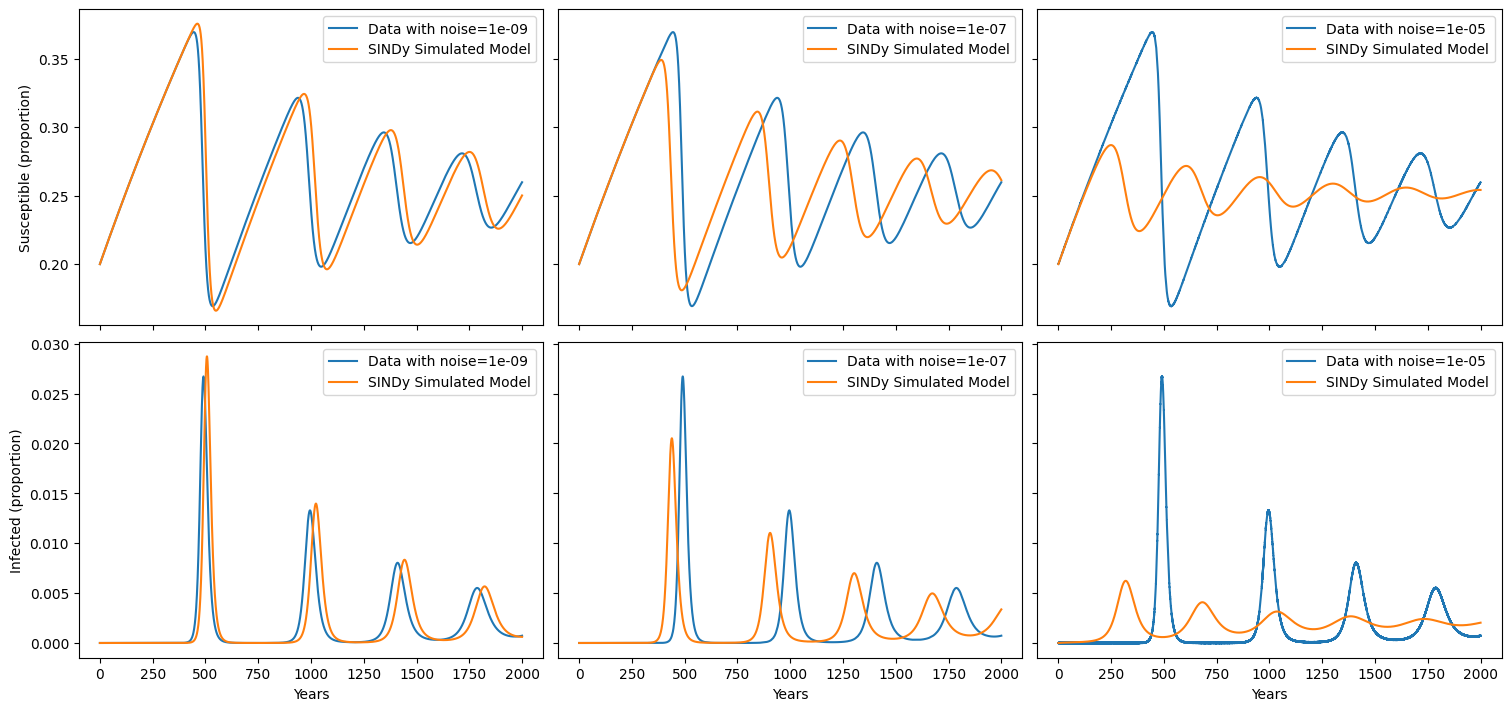

In [273]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 7), sharex='col', sharey='row', layout="constrained")

ax1.plot(t, Slight, label=f"Data with noise={light_noise_value}")
ax1.plot(t, sim_light[:,0], label=f"SINDy Simulated Model")
ax1.set_ylabel('Susceptible (proportion)')
ax1.legend()

ax4.plot(t, Ilight, label=f"Data with noise={light_noise_value}")
ax4.plot(t, sim_light[:,1], label=f"SINDy Simulated Model")
ax4.set_ylabel('Infected (proportion)')
ax4.set_xlabel('Years')
ax4.legend()

ax2.plot(t, Smed, label=f"Data with noise={med_noise_value}")
ax2.plot(t, sim_med[:,0], label=f"SINDy Simulated Model")
ax2.legend()

ax5.plot(t, Imed, label=f"Data with noise={med_noise_value}")
ax5.plot(t, sim_med[:,1], label=f"SINDy Simulated Model")
ax5.set_xlabel('Years')
ax5.legend()

ax3.plot(t, Slarge, label=f"Data with noise={heavy_noise_value}")
ax3.plot(t, sim_large[:,0], label=f"SINDy Simulated Model")
ax3.legend()

ax6.plot(t, Ilarge, label=f"Data with noise={heavy_noise_value}")
ax6.plot(t, sim_large[:,1], label=f"SINDy Simulated Model")
ax6.set_xlabel('Years')
ax6.legend()

plt.show()

In [277]:
def print_table_coefficients(model_to_print, delim="|", latex_ready=False):
    
    model_to_print.get_feature_names()

    if latex_ready:
        delim = " & "

    if latex_ready:
        print("\\begin{tabular}{|c|c|c|}")
        print("\\hline")
        print("Term", delim, "S Eq", delim, "I Eq \\\\")
        print("\\hline")
    else: 
        print("Term", delim, "S Eq", delim, "I Eq")
    
    displayed_feature_names = np.array([])

    for i in range(0,len(model_to_print.get_feature_names())):
        curr_name = model_to_print.get_feature_names()[i]
        if np.isin(curr_name, displayed_feature_names):
            continue
        displayed_feature_names = np.append(displayed_feature_names, curr_name)
        if latex_ready:
            print(curr_name, delim , "{:.10f}".format(model_to_print.coefficients()[0][i]), delim, "{:.10f}".format(model_to_print.coefficients()[1][i]), "\\\\")
        else:
            print(curr_name, delim , "{:.10f}".format(model_to_print.coefficients()[0][i]), delim, "{:.10f}".format(model_to_print.coefficients()[1][i]))
    if latex_ready:
        print("\\hline")
        print("\\end{tabular}")

In [278]:
print_table_coefficients(light_noise_model, latex_ready=True)

\begin{tabular}{|c|c|c|}
\hline
Term  &  S Eq  &  I Eq \\
\hline
1  &  0.0000052675  &  0.0000000000 \\
S  &  0.4998763035  &  -0.0000000000 \\
I  &  0.0000000000  &  0.4979536821 \\
beta  &  0.0000000811  &  0.0000000000 \\
S I  &  -0.0076950944  &  0.0076950944 \\
S beta  &  0.0076941020  &  -0.0000000000 \\
I beta  &  0.0000000000  &  0.0076645090 \\
S I beta  &  -0.0001184430  &  0.0001184430 \\
S^2  &  -0.0000000000  &  0.0000000000 \\
I^2  &  0.0000000002  &  -0.0000000001 \\
beta^2  &  0.0000000012  &  0.0000000000 \\
\hline
\end{tabular}


In [275]:
print_table_coefficients(med_noise_model, latex_ready=True)

\begin{tabular}{|c|c|c|}
\hline
Term  &  S Eq  &  I Eq \\
\hline
1  &  0.0000052675  &  0.0000000000 \\
S  &  0.4998763037  &  0.0000000002 \\
I  &  0.0000000003  &  0.4979536803 \\
beta  &  0.0000000811  &  0.0000000000 \\
S I  &  0.0076950945  &  0.0076950956 \\
S beta  &  0.0076941020  &  0.0000000000 \\
I beta  &  0.0000000000  &  0.0076645089 \\
S I beta  &  0.0001184430  &  0.0001184430 \\
S^2  &  0.0000000004  &  0.0000000007 \\
I^2  &  0.0000000186  &  0.0000001309 \\
beta^2  &  0.0000000012  &  0.0000000000 \\
\hline
\end{tabular}


In [276]:
print_table_coefficients(large_noise_model, latex_ready=True)

\begin{tabular}{|c|c|c|}
\hline
Term  &  S Eq  &  I Eq \\
\hline
1  &  0.0000052827  &  0.0000000788 \\
S  &  0.4998762102  &  0.0000004206 \\
I  &  0.0000001593  &  0.4979395965 \\
beta  &  0.0000000813  &  0.0000000012 \\
S I  &  0.0076949037  &  0.0076892337 \\
S beta  &  0.0076941005  &  0.0000000065 \\
I beta  &  0.0000000025  &  0.0076642922 \\
S I beta  &  0.0001184400  &  0.0001183528 \\
S^2  &  0.0000002630  &  0.0000013545 \\
I^2  &  0.0000135815  &  0.0013748721 \\
beta^2  &  0.0000000013  &  0.0000000000 \\
\hline
\end{tabular}
